# Solution - Exam 3

## Imports

In [1]:
import pandas as pd
import numpy as np
import random

import warnings

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import seaborn as sns

In [2]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance 

## Data

In [3]:
DATAFILE = 'exam_3_data.xlsx'

In [4]:
rets = pd.read_excel(DATAFILE,sheet_name='returns').set_index('date')
rets

,SPY,EFA,EEM,PSP,QAI,HYG,DBC,IYR,IEF,BWX,TIP
date,,,,,,,,,,,
2009-04-30,0.099346,0.115190,0.155583,0.230202,0.022882,0.138460,-0.001000,0.296151,-0.027452,0.008993,-0.017951
2009-05-31,0.058453,0.131918,0.159400,0.053892,0.027865,0.028556,0.162663,0.022727,-0.020772,0.053672,0.019967
2009-06-30,-0.000655,-0.014049,-0.022495,0.045449,-0.003437,0.033517,-0.026259,-0.024863,-0.005572,0.005149,0.001981
2009-07-31,0.074606,0.100415,0.110146,0.143247,0.015326,0.069190,0.018568,0.105799,0.008316,0.031284,0.000879
2009-08-31,0.036939,0.045031,-0.013136,0.033413,-0.004151,-0.016969,-0.040365,0.131939,0.007634,0.007628,0.008414
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,-0.052741,-0.036350,-0.000205,-0.086028,-0.020761,-0.026549,0.078922,-0.082314,-0.021130,-0.026176,-0.020588
2022-02-28,-0.029517,-0.034292,-0.043202,-0.073602,-0.006746,-0.008590,0.064674,-0.045881,-0.003041,-0.011197,0.008557
2022-03-31,0.037590,0.005190,-0.033811,-0.007721,-0.002587,-0.012871,0.091747,0.068646,-0.040609,-0.042240,-0.018755


# 1 OLS Regression

In [5]:
def estimate_reg(X,y,model=LinearRegression,penalty=None,DoIntercept=True):
    if model is LinearRegression:
        mod = LinearRegression(fit_intercept=DoIntercept).fit(X,y)
    else:
        mod = model(alpha=penalty, fit_intercept=DoIntercept).fit(X,y)
    
    estimates = pd.Series(index = list(X.columns) + ['r-squared'], dtype=float)
    estimates.loc[X.columns] = mod.coef_
    
#    if DoIntercept:
#        estimates = pd.concat([pd.Series(index=['intercept'], data=mod.intercept_), estimates]) 
    estimates.loc['r-squared'] = mod.score(X,y)
    
    return estimates

### 1.1 & 1.2

In [6]:
TARGET = 'IYR'
REG_UNI = 'IEF'
REG_MULTI = [REG_UNI,'SPY']

y = rets[TARGET]
x = rets[[REG_UNI]]
X = rets[REG_MULTI]
Xall = rets.drop(columns=[TARGET])

__*(a)*__

In [7]:
ols = pd.DataFrame(columns=['uni','multi'], index=list(X.columns)+['r-squared'], dtype=float)
ols['uni'] = estimate_reg(x,y)
ols['multi'] = estimate_reg(X,y)

ols.style.format('{:.1%}')

,uni,multi
IEF,-17.8%,63.1%
SPY,nan%,102.8%
r-squared,0.3%,56.9%


__*(b)*__ From the OLS model, we see that although bond returns (IEF) and real estate returns (IYR) may be associated with each other, IEF certainly does a poor job of explaining the variation in IYR returns. In particular, we see that the coefficient on IEF is non-zero for both regressions (see question 1.2), which indicates that changes in IEF are *associated* with changes in IYR, at least in sample. To further assess this association, or at least our confidence in the discovery, we could look at the t-statistics.

### 1.3

__*(a)*__

In [8]:
pd.concat([X, y], axis=1).corr()

,IEF,SPY,IYR
IEF,1.000000,-0.329349,-0.057867
SPY,-0.329349,1.000000,0.729377
IYR,-0.057867,0.729377,1.000000


__*(b)*__ The correlation matrix above shows a negative correlation between IEF and SPY, which reflects the positive shift in $\beta^{IEF}$ after including SPY in the regression. In the univariate regression, $\beta^{IEF}$ was negative, as IEF has a negative correlation to IYR. However, it is also negatively correlated to SPY, which itself has a positive relationship with IYR. As a result, when we include SPY in our regression, IEF no longer needs to explain SPY's association with IYR which leads to the shift in $\beta^{IEF}$.

### 1.4
Some important classical t-stats assumptions include:
1) Homoskedasticity\
2) No serial correlation\
3) Normally distributed residuals

These are not obviously violated here. The regression involves returns, which have low serial correlation. Even if the data isn't close to being normally distributed, we have a large enough sample to rely on the CLT.

This was not required, but we can briefly visualize some of these assumptions with plots such as the ones below.

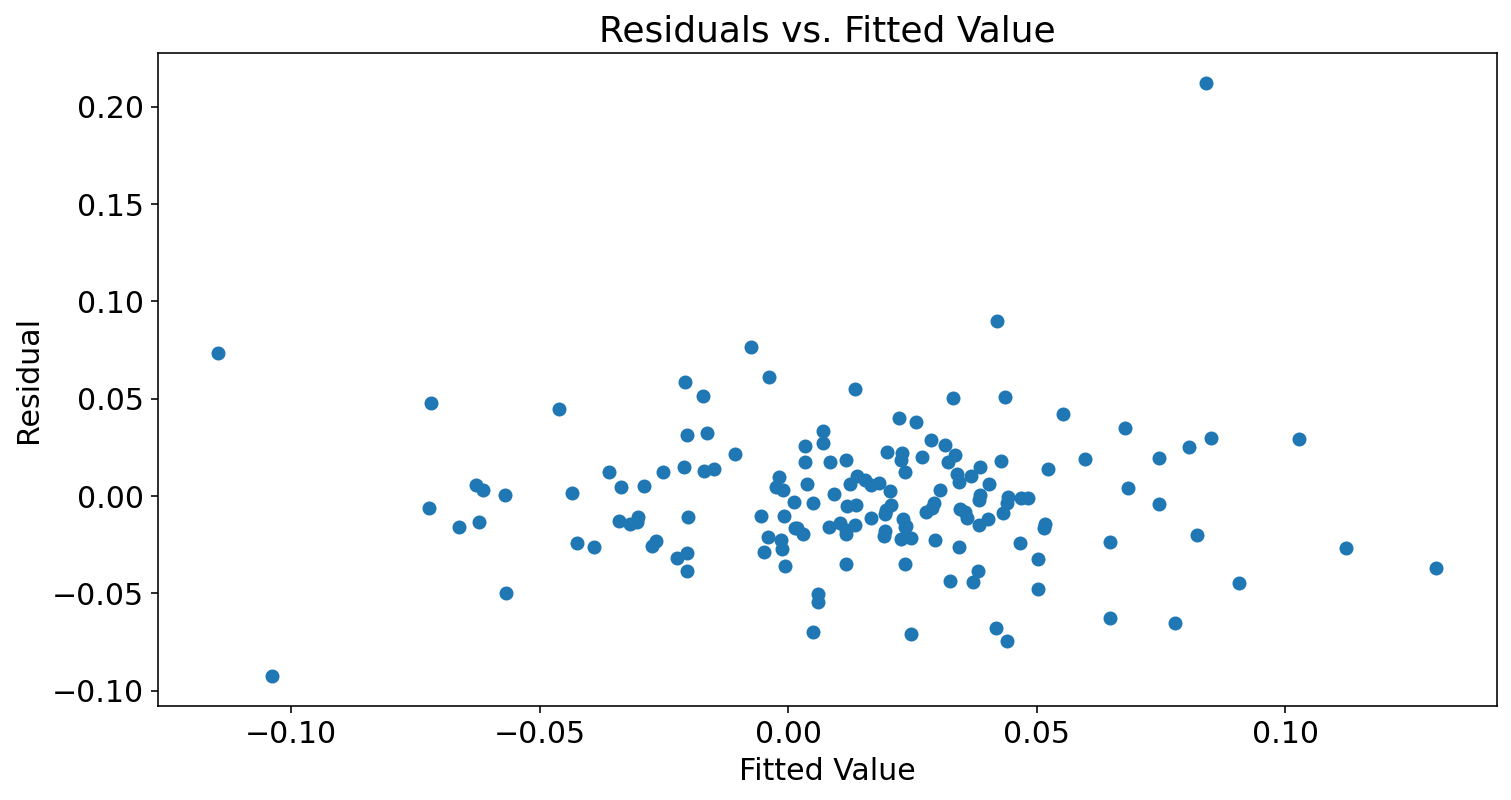

In [36]:
model = sm.OLS(y, X).fit()

plt.scatter(x=model.fittedvalues, y=model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residuals vs. Fitted Value')
plt.show()

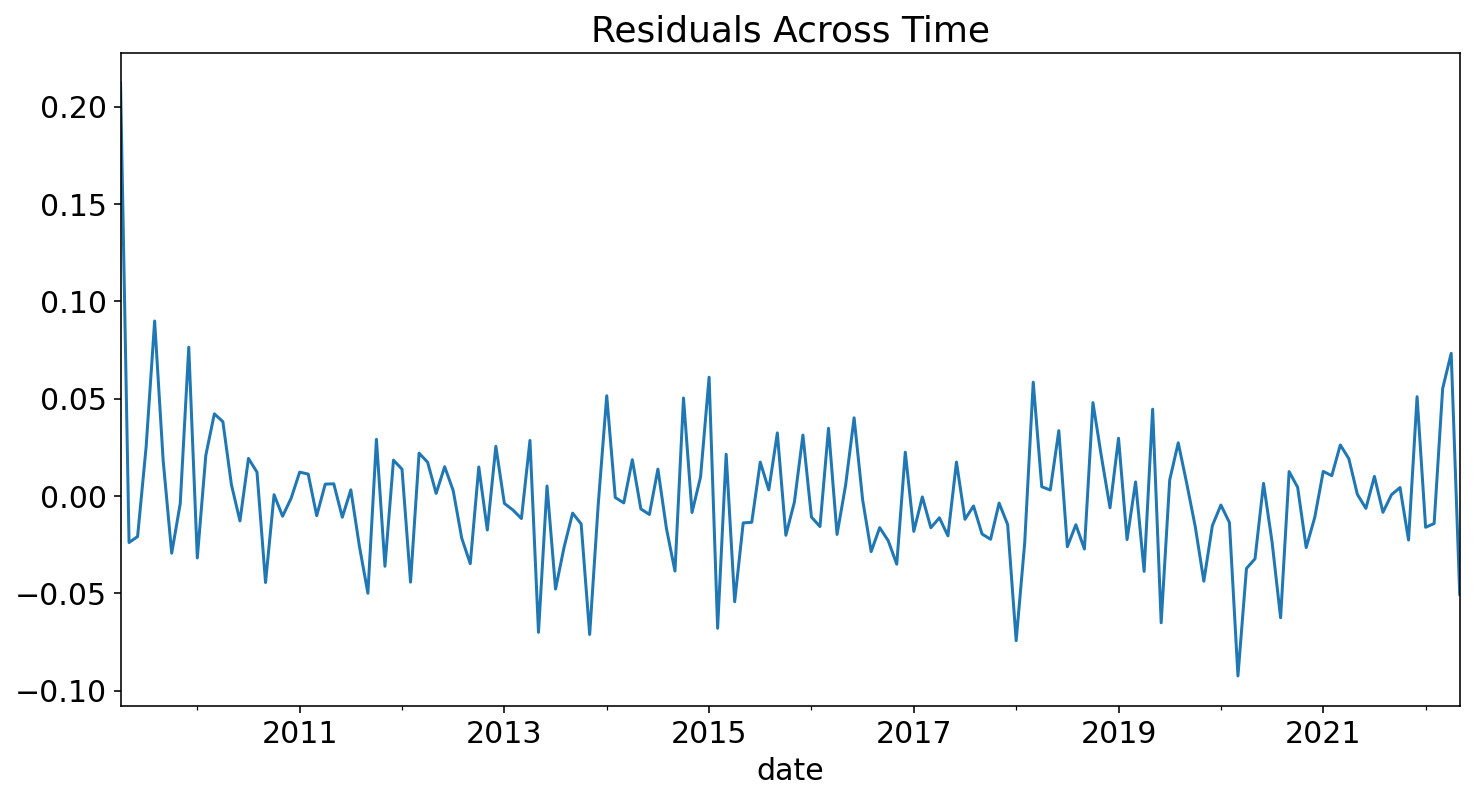

In [37]:
model.resid.plot(title='Residuals Across Time')
plt.show()

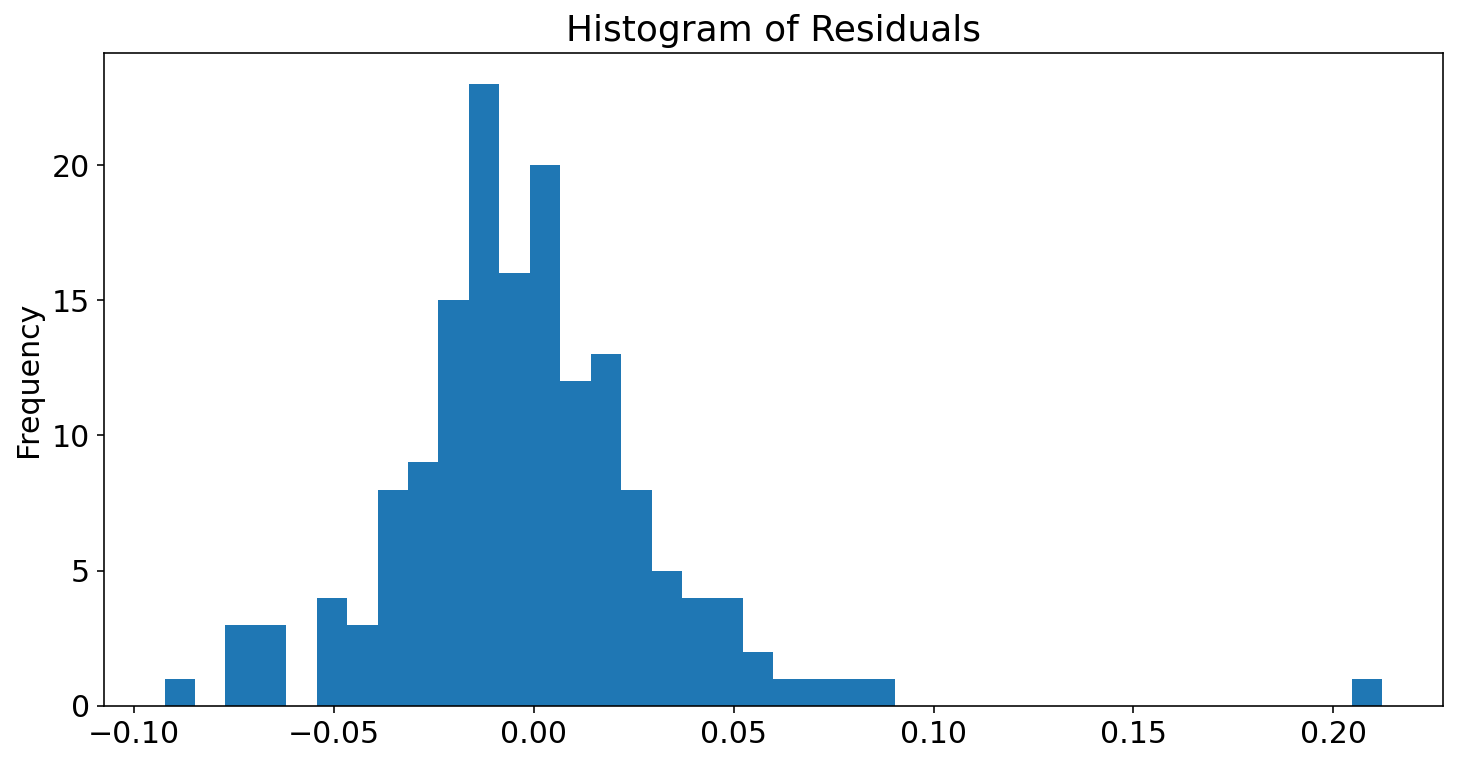

In [38]:
model.resid.plot(kind='hist', bins=40, title='Histogram of Residuals')
plt.show()

From a visual perspective, we can see our model does not violate all of these assumptions to an extreme degree.

Aside from just worrying about t-stats, we could ask whether the model is well-specified. 
* It seems to be stationary data
* We do not have a problem with multicolinearity

#### Another possible problem: Omitted variable bias. 
We may expect our estimates to be susceptible to omitted variables bias if we are missing certain variables, which in conjunction with t-stats can lead to false discoveries and interpretations.

# 2 Forecasting

### 2.1

__*(a), (b)*__

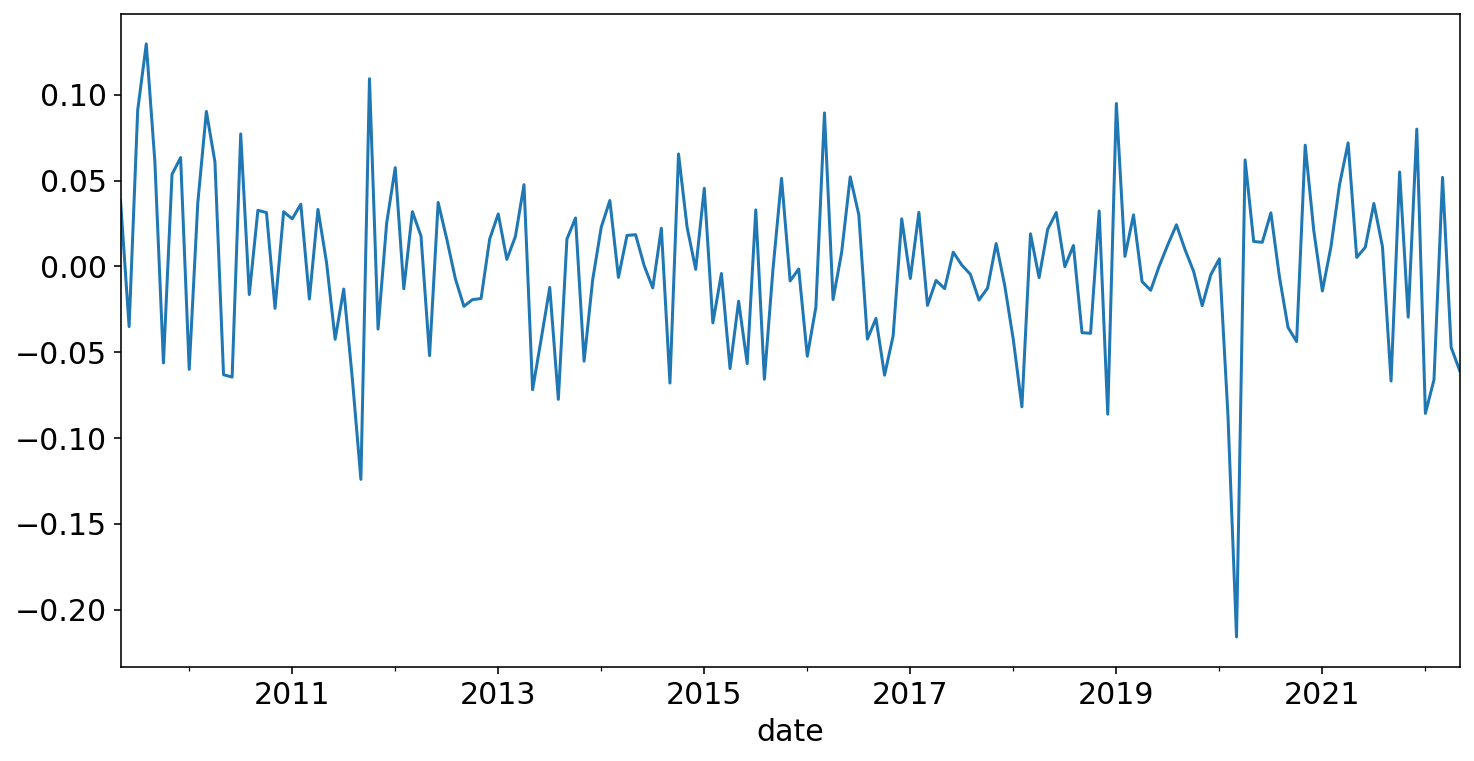

In [9]:
z = y.to_frame().shift().dropna()
z, pred = z.align(y,join='inner',axis=0)

mod = LinearRegression().fit(z,pred)

forecast_beta = mod.coef_
forecast_r2 = mod.score(z,pred)

forecast_resids = pred - mod.predict(z)
forecast_resids.plot();

In [10]:
forecast_r2

0.011055617153393649

In [11]:
forecast_beta

array([-0.09529034])

From our plot above, it seems that the sample residuals do not seem to have substantial serial correlation. The implications of this are further discussed below.

### 2.2

__*(a)*__ At most, 
* misspecified significance levels

The multivariate regression is contemporaneous returns, so it is unlikely to have much serial correlation. Thus, this regression may not have any of the three problems.

Still, it is possible that the errors have some serial correlation, and if they do, it would still only lead to the problem of missspecified significance levels.

__*(b)*__ At least
* biased beta estimates in small samples
* misspecified significance levels
And possibly,
* biased beta estimates in large samples.

Now the errors are also correlated with other observations of the $y$ variable. This will surely bias beta. And it will likely mess up the significance levels.

#### More nuanced issue
Whether it causes bias in large samples depends on whether there is serial correlation in the residuals. In HW 2, this was a major feature, but those regressors had high serial correlation (inflation, monetary growth.) The regressor here is a return, so it has low serial correlation.

### 2.3

__*(a)*__ Yes, the estimated beta would likely change substantially, as there is no reason that the relationship between the two price series would be the same as the relationship between the two returns series. The r-squared is also likely to be quite high as well, because both series are trending upward, meaning they move together tightly.

__*(b)*__ This version is surely a "spurious regression" due to the data not being stationary! Thus, as we learned in Session 2, it is inappropriate to estimate a regression in this nonstationary form. 

### 2.4

### Volatility

In [42]:
FREQ = 12
WIN = 2

TARG_GARCH = 'DBC'
var_1 = .01

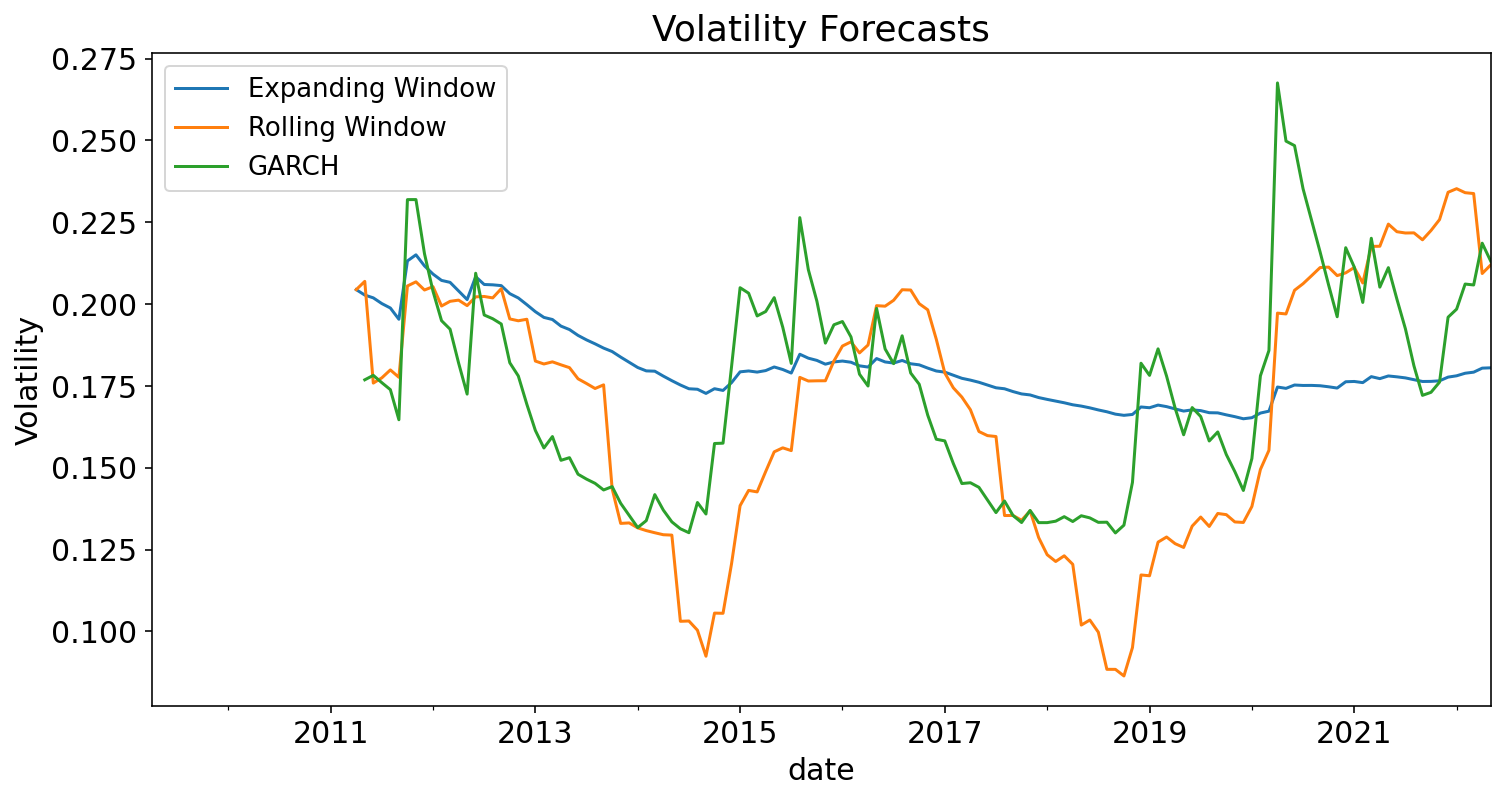

In [43]:
### Expanding Window
ygarch = rets[TARG_GARCH]
var = (ygarch**2).shift(1).expanding(min_periods=FREQ*WIN).mean().to_frame()
var.columns = ['Expanding Window']

### Rolling Window
var['Rolling Window'] = (ygarch**2).shift(1).rolling(WIN*FREQ).mean() 

SCALE = 100
yscld = ygarch * SCALE
GARCH = arch_model(yscld, vol='Garch', p=1, o=0, q=1, dist='Normal')
GARCH_model = GARCH.fit(disp='off')
garch_alt = GARCH_model.forecast(horizon=1,start=ygarch.index[FREQ*WIN],align='target').variance

var['GARCH'] = garch_alt / SCALE**2

### Convert variance to volatility
vol = (var * FREQ)**.5

vol.plot()
plt.title('Volatility Forecasts')
plt.ylabel('Volatility')
plt.show()

In [44]:
dts = ['2020-04-30','2022-05-31']
vol.loc[dts]

,Expanding Window,Rolling Window,GARCH
date,,,
2020-04-30,0.174661,0.197237,0.267544
2022-05-31,0.180528,0.211956,0.213103


# Penalized Regression

### 3.1

In [45]:
PENALTY_ridge=5e-1
PENALTY_lasso = 2e-4

T = '2019'
T1 = '2020'

Xt = Xall[:T]
yt = y[:T]

reg = pd.DataFrame(index=list(Xt.columns)+['r-squared'], dtype=float)
reg['ols'] = estimate_reg(Xt,yt)
reg['ridge'] = estimate_reg(Xt,yt,model=Ridge,penalty=PENALTY_ridge)
reg['lasso'] = estimate_reg(Xt,yt,model=Lasso,penalty=PENALTY_lasso)

reg.style.format('{:.1%}')

,ols,ridge,lasso
SPY,90.8%,11.0%,13.6%
EFA,5.3%,9.6%,0.0%
EEM,10.8%,11.4%,5.1%
PSP,4.4%,15.7%,30.0%
QAI,-164.5%,2.1%,0.0%
HYG,109.0%,10.0%,42.9%
DBC,-21.9%,-2.7%,-5.7%
IEF,80.1%,2.9%,0.0%
BWX,4.5%,3.2%,0.0%
TIP,32.2%,2.7%,0.0%


In [16]:
print(f'Size (L1) of beta estimates:\n{reg.iloc[:-1,:].abs().sum()}\n\n')
print(f'Number of non-zero beta estimates:\n{(reg.iloc[:-1,:].abs()>1e-6).sum()}')

Size (L1) of beta estimates:
ols      5.234418
ridge    0.712614
lasso    0.973019
dtype: float64


Number of non-zero beta estimates:
ols      10
ridge    10
lasso     5
dtype: int64


We see that ridge and lasso generally have smaller betas, many of which are 0 for lasso, which is to be expected.

### 3.2

In [46]:
Xt.corr()

,SPY,EFA,EEM,PSP,QAI,HYG,DBC,IEF,BWX,TIP
SPY,1.000000,0.866534,0.770723,0.880032,0.789765,0.723324,0.532333,-0.430732,0.347099,-0.025633
EFA,0.866534,1.000000,0.864663,0.903705,0.804057,0.744558,0.584627,-0.362262,0.553046,0.069738
EEM,0.770723,0.864663,1.000000,0.818276,0.788988,0.734362,0.596593,-0.272977,0.601506,0.188517
PSP,0.880032,0.903705,0.818276,1.000000,0.755128,0.811265,0.501326,-0.402218,0.429549,0.015117
QAI,0.789765,0.804057,0.788988,0.755128,1.000000,0.698436,0.565595,-0.100092,0.601683,0.280105
HYG,0.723324,0.744558,0.734362,0.811265,0.698436,1.000000,0.500861,-0.205746,0.453230,0.129386
DBC,0.532333,0.584627,0.596593,0.501326,0.565595,0.500861,1.000000,-0.346769,0.443634,0.106506
IEF,-0.430732,-0.362262,-0.272977,-0.402218,-0.100092,-0.205746,-0.346769,1.000000,0.264023,0.709324
BWX,0.347099,0.553046,0.601506,0.429549,0.601683,0.453230,0.443634,0.264023,1.000000,0.502828
TIP,-0.025633,0.069738,0.188517,0.015117,0.280105,0.129386,0.106506,0.709324,0.502828,1.000000


It is immediately apparent that the regressors are quite correlated, as financial data frequently is. From a regression standpoint, we should then be wary that our model may be distorted by multicollinearity, which can have the effect of making our model's estimates very sensitive to the data used to train it. As a result, our model is unlikely to have meaningful interpretation nor be predictive out of sample.

### 3.3

Ridge estimates the betas to be smaller in magnitude, but still makes use of all of them, (all are nonzero.)

This is as expected, given Ridge's L2 penalty.

Ridge is useful in dealing with multicollinearity, particularly when we still believe that every regressor is useful/predictive. It allows us to make room for what the model deems to be the most "important" variables while still preserving the information granted to us by the other variables.

### 3.4

The LASSO estimates are mostly zero, while those not zero show little penalty relative to OLS.

This is as expected given the L1 penalty of LASSO.

Note that QAI had the largest (in magnitude) beta for OLS, but was forced to zero with Lasso. That is because QAI was correlated with another regressor that was more useful. This leads Lasso to force QAI's beta to zero to "make room" for the other regressor. Another observation common to Lasso is that many of our betas are now zero.

Lasso is useful as a *dimensionality reduction* technique. Regardless of whether we want to simplify our model, or we believe that some regressors are either useless or redundant, Lasso helps us select a subset of regressors to use. As such, it is used in both prediction settings and when we are looking to make causal/associative discoveries. Similarly to ridge, it is also useful when dealing with multicollinearity.

In [47]:
X_train = Xall[:T].copy()
y_train = y[:T].copy()
X_test = Xall[T1:].copy()
y_test = y[T1:].copy()

In [48]:
ols_train = LinearRegression().fit(X_train,y_train)
ridge_train = Ridge(alpha=PENALTY_ridge).fit(X_train,y_train)
lasso_train = Lasso(alpha=PENALTY_lasso).fit(X_train,y_train)

rsquared = pd.DataFrame(index=['ols','ridge','lasso'],columns=['in-sample','out-of-sample'],dtype=float)
rsquared['in-sample'] = reg.loc['r-squared']

rsquared['out-of-sample'] = [ols_train.score(X_test,y_test),                            
                           ridge_train.score(X_test,y_test),
                           lasso_train.score(X_test,y_test)]

rsquared.style.format('{:.1%}')

,in-sample,out-of-sample
ols,70.7%,47.6%
ridge,45.2%,60.6%
lasso,54.1%,72.8%
